# This script is used to calculate the indices associated with extreme climate events.

In [216]:
import xclim
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
from xclim import units
import geopandas as gpd
from shapely.geometry import mapping
import rioxarray
import numpy as np
import pandas as pd
import openpyxl
import seaborn as sns
from scipy import stats

## You should define your own data path in Here

In [185]:
era5_temp = xr.open_dataset('/workdir/cgl/WHs_Climate/era5_daily/handle/daily_mean_2m_temperature2005-2014.nc')
era5_pr = xr.open_dataset('/workdir/cgl/WHs_Climate/era5_daily/handle/daily_mean_total_precipitation2005-2014.nc')

###  calculate TXx (extreme heat)

In [12]:
era5_TXx = xclim.atmos.tg_max(tas='t2m',ds=era5_temp,freq='YS')

/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(


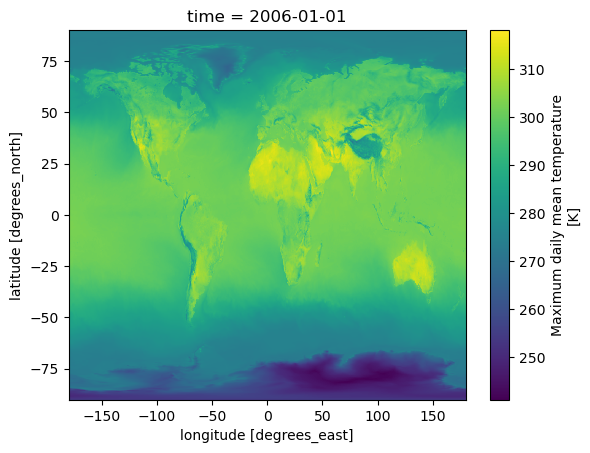

In [35]:
era5_TXx[1,:,:].plot()

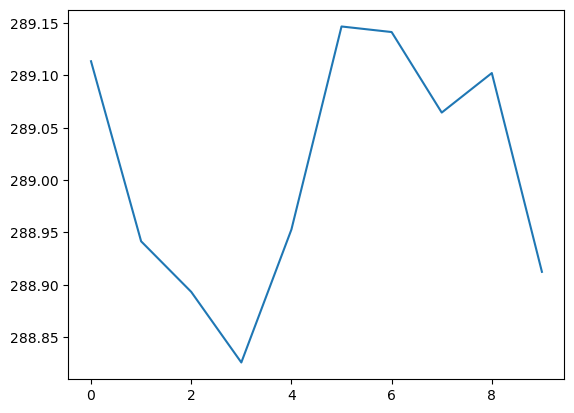

In [32]:
plt.plot(era5_TXx.groupby('time').mean(dim={'lat','lon'}))

### calculate TG90P (extreme heat)

In [23]:
era5_tas_reference = era5_temp.sel(time=slice('2005-01-01','2009-12-31'))

In [27]:
era5_reference_date_p90 = xclim.core.calendar.percentile_doy(era5_tas_reference.t2m,per=90)
era5_reference_date_p90_chunk = era5_reference_date_p90.chunk({'dayofyear':'auto'})

In [30]:
with ProgressBar():
    era5_TG90P = xclim.indicators.atmos.tg90p(tas='t2m', tas_per=era5_reference_date_p90_chunk, freq='QS-DEC', ds=era5_temp,bootstrap=True).compute()

/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(


[########################################] | 100% Completed | 7.47 ss


In [ ]:
era5_TXx.to_netcdf('/workdir/cgl/WHs_Climate/future/era5/era5_TXx.nc')
era5_TG90P.to_netcdf('/workdir/cgl/WHs_Climate/future/era5/era5_TG90P.nc')

### calculate Rx1day (extreme heat)
### note:The unit for rainfall is meters; multiply by 1000 to convert to millimeters.

In [60]:
era5_pr['tp'] = era5_pr['tp']*1000

In [62]:
era5_pr = era5_pr.rename(tp="pr")

In [75]:
era5_pr.pr.attrs['units']="mm/day"

In [76]:
era5_pr_rx1day = xclim.indicators.atmos.max_1day_precipitation_amount(pr='pr',freq='YS',ds=era5_pr)

/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


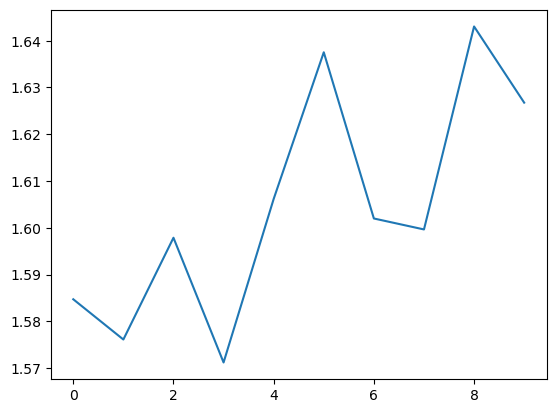

In [81]:
plt.plot(era5_pr_rx1day.groupby('time').mean({'lat','lon'}))

### calculate R95P

In [84]:
era5_pr_reference = era5_pr.pr.sel(time=slice('2005-01-01','2009-12-31'))
era5_pr_reference_p95 = xclim.core.calendar.percentile_doy(era5_pr_reference,per=95)
era5_pr_reference_p95_chunk = era5_pr_reference_p95.chunk({'dayofyear':'auto'})

In [86]:
with ProgressBar():
    era5_pr_R95P = xclim.indicators.icclim.R95p(pr='pr', pr_per=era5_pr_reference_p95, freq='YS', ds=era5_pr).compute()

/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:42: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(
/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/core/cfchecks.py:46: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


In [91]:
era5_pr_rx1day.to_netcdf('/workdir/cgl/WHs_Climate/future/era5/era5_rx1day.nc')
era5_pr_R95P.to_netcdf('/workdir/cgl/WHs_Climate/future/era5/era5_R95P.nc')

### calculate SPEI

In [92]:
wb_era5= xclim.indices.water_budget(pr=era5_pr.pr, tas =era5_temp.t2m, method="MB05")

In [96]:
gdf = gpd.read_file('/workdir/cgl/WHs_Climate/shp/World_heritageall.shp')

In [101]:
wb_era5.rio.write_crs("epsg:4326", inplace=True)
wb_era5_WHS = wb_era5.rio.clip(gdf.geometry.apply(mapping),gdf.crs,drop=True,invert=False)

In [104]:
wb_era5_WHS_1d = wb_era5_WHS.stack(site=['lat', 'lon']).dropna('site')

In [105]:
SPEI_era5=xclim.indices.standardized_precipitation_evapotranspiration_index(wb=wb_era5_WHS_1d,freq='MS',window=6)

/home/cgl/anaconda3/envs/py311/lib/python3.11/site-packages/xclim/indices/_agro.py:1306: UserWarning: Inputting an offset will be deprecated in xclim>=0.50.0. 
  warnings.warn("Inputting an offset will be deprecated in xclim>=0.50.0. ")


In [106]:
SPEI_era5_2d = SPEI_era5.unstack('site').reindex(lat=wb_era5_WHS.lat, lon=wb_era5_WHS .lon)

In [107]:
SPEI_era5_2d.to_netcdf('/workdir/cgl/WHs_Climate/future/era5/era5_SPEI.nc')